# Imports

In [236]:
import os
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Description

Files were listed from their locations in the two datasets' GCS buckets using `gsutil` like so:

![image](file_sizes_images/gsutil_listing_buckets_files.png)

The head of the listing looks like the following, where the first column is the file size in bytes:

![image](file_sizes_images/gsutil_listing_contents.png)

The rest of this notebook loads the three datasets' file sizes together, produces some descriptive stats from them, and plots what the distribution looks like. This is used with the intent of picking a sensible square dimension for images to reshape the bytes of the files to.

# Data

In [237]:
data_dir = './file_sizes_analysis_data'
file_paths = [f'{os.path.join(data_dir, f)}' for f in os.listdir(data_dir)]
file_paths

['./file_sizes_analysis_data/pdf_benign_files',
 './file_sizes_analysis_data/pdf_malicious_files',
 './file_sizes_analysis_data/sorel20m_resampled_files']

In [238]:
columns = ['size_bytes', 'modify_time_utc', 'path']
df = (pd.concat((pd.read_csv(f, sep='\s+', index_col=None, names=columns) for f in file_paths))
      .loc[lambda df_x: df_x.size_bytes != 0] # some of the pdfs have zero size?
      .reset_index(drop=True)
      .assign(size_kilobytes = lambda df_x: df_x.size_bytes / 1_000)
      .assign(size_megabytes = lambda df_x: df_x.size_bytes / 1_000_000)
      .assign(dataset = lambda df_x: np.where(df_x.path.str.contains('drexel_dsci_2022_g4mic'), 'pdf', 'sorel'))
      .assign(kind = lambda df_x: np.where(df_x.path.str.contains('Benign'), 'benign', 'malicious'))
     )
display(df.head())
display(df.info())

,size_bytes,modify_time_utc,path,size_kilobytes,size_megabytes,dataset,kind
0,396936,2022-04-30T14:28:00Z,gs://drexel_dsci_2022_g4mic/Benign/unzipped/02...,396.94,0.40,pdf,benign
1,250800,2022-04-30T14:28:00Z,gs://drexel_dsci_2022_g4mic/Benign/unzipped/02...,250.80,0.25,pdf,benign
2,246975,2022-04-30T14:28:00Z,gs://drexel_dsci_2022_g4mic/Benign/unzipped/02...,246.97,0.25,pdf,benign
3,367605,2022-04-30T14:28:00Z,gs://drexel_dsci_2022_g4mic/Benign/unzipped/02...,367.61,0.37,pdf,benign
4,32782,2022-04-30T14:28:00Z,gs://drexel_dsci_2022_g4mic/Benign/unzipped/03...,32.78,0.03,pdf,benign


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49608 entries, 0 to 49607
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   size_bytes       49608 non-null  int64  
 1   modify_time_utc  49608 non-null  object 
 2   path             49608 non-null  object 
 3   size_kilobytes   49608 non-null  float64
 4   size_megabytes   49608 non-null  float64
 5   dataset          49608 non-null  object 
 6   kind             49608 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 2.6+ MB


None

# File Size

The goal of looking at both datasets' file sizes is to find a height and width value to use that strikes a balance between capturing as many bytes as possible from all files while not requiring the excessive space that would be needed with a greatest common factor dimension that captures all files' bytes. The nearest (conservative) integer value to the square root of the value chosen will serve as the square dimension used when converting the contents of both datasets to mnist-style images, a square bag of uint8 bytes.

In [239]:
pd.set_option('display.float_format','{:.2f}'.format)
df.size_bytes.describe()

count       49608.00
mean       440921.56
std       2403778.31
min            24.00
25%          9858.00
50%         44434.50
75%        239423.00
max     160637719.00
Name: size_bytes, dtype: float64

## Byte Size by Dataset Histogram

Since what was found below shows that the distribution of file sizes between the datasets is multimodal, picking the median as originally intended for the most basic approach won't make sense. One approach could be to take advantage of the right skew caused by the sorel datasets' file sizes by picking the mean plus 0.5sd. This seems to cut a good initial balance between samples from both datasets.

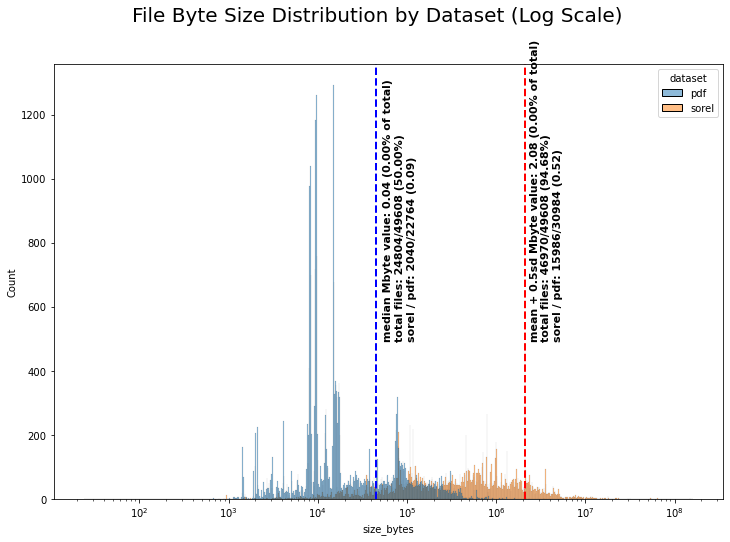

In [240]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.histplot(data=df,
             x='size_bytes',
             hue='dataset',
             ax=ax,
             bins=1000,
             log_scale=True,
             )

fig.suptitle('File Byte Size Distribution by Dataset (Log Scale)', fontsize=20)

def add_vline(data, name, stat, color, ax, h_adj=1e5, v_adj=500):
    '''helper to add a vertical line showing chosen byte size and details
    about what files are included when using this line'''
    files = data.loc[lambda df_x: df_x.size_bytes <= stat]
    files_byte_coverage = stat / data.size_bytes.sum()
    sorel_files = files.loc[lambda x: x.dataset == 'sorel']
    pdf_files = files.loc[lambda x: x.dataset == 'pdf']
    ax.axvline(stat, color=color, linewidth=2, linestyle='--')
    text = '\n'.join([
        f'{name} Mbyte value: {stat/1_000_000:.02f} ({files_byte_coverage / 1_000_000 * 100:.02f}% of total)',
        f'total files: {files.shape[0]}/{data.shape[0]} ({files.shape[0] / data.shape[0] * 100:.02f}%)',
        f'sorel / pdf: {sorel_files.shape[0]}/{pdf_files.shape[0]} ({sorel_files.shape[0] / pdf_files.shape[0]:.02f})',
    ])
    ax.text(stat + h_adj, v_adj, text, fontsize=11, fontweight='demibold', rotation=90)

add_vline(df, 'median', df.size_bytes.median(), color='blue', ax=ax, h_adj=1e4)
#add_vline(df, 'mean', df.size_bytes.mean(), color='red', ax=ax)
add_vline(df, 'mean + 0.5sd', df.size_bytes.mean() + df.size_bytes.mean() + 0.5 * df.size_bytes.std(), color='red', ax=ax, h_adj=3*1e5)

## Byte Size by Dataset Box Plot

Using this boxplot as reference instead, a more ideal way to cut a sensible balance between the datasets overall seems to be by using the highlighted region; it contains only files that are within the sorel dataset's 0th percentile size through its 75th percentile size. This will capture the densest parts of both datasets in byte volume, and it will also serve to clip outlier sizes, where the sorel-20m is particularly the heaviest in terms of storage cost, from both datasets effectively.

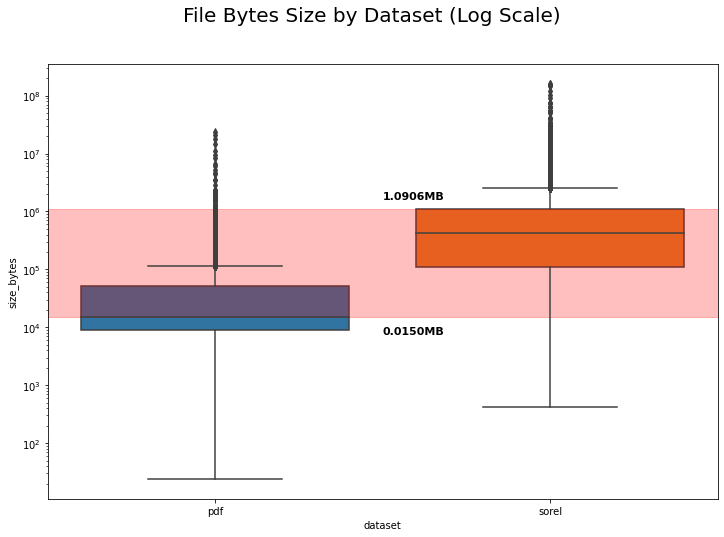

In [241]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.boxplot(data=df,
            x='dataset',
            y='size_bytes',
            )
ax.set_yscale('log')

lower_bound = df.loc[lambda x: x.dataset == 'pdf'].size_bytes.quantile(0.5)
upper_bound = df.loc[lambda x: x.dataset == 'sorel'].size_bytes.quantile(0.75)

clip_range = (lower_bound, upper_bound)
ax.axhspan(*clip_range, color='red', alpha=0.25)
ax.text(0.5, clip_range[0] - 0.5 * clip_range[0], f'{clip_range[0] / 1_000_000:.04f}MB', fontsize=11, fontweight='demibold')
ax.text(0.5, clip_range[1] + 0.5 * clip_range[1], f'{clip_range[1] / 1_000_000:.04f}MB', fontsize=11, fontweight='demibold')

_ = fig.suptitle('File Bytes Size by Dataset (Log Scale)', fontsize=20)

## Clipped Byte Size by Dataset Histogram

Here's the original histogram, plotted twice using the suggested clipping described above as well as an adjustment following a take-away from the first chart. What was found is that the mean and median with the clipped file sizes looks better, but the proportion of samples from both datasets that could be used with this filter was still pretty imbalanced. The imbalance comes from a dense portion of files in the pdf dataset whose sizes are right around the median value of the pdf dataset's files. What seems to strike a good balance (0.97 ratio of sorel files to pdf files) is clipping just above the pdf malware's median and choosing the value that's +1.5 std from the mean to accommodate for the heavier size of the sorel dataset's files. This yields a relatively balanced proportion of pdf and sorel files in terms of byte density.

### Using Suggested Clipping

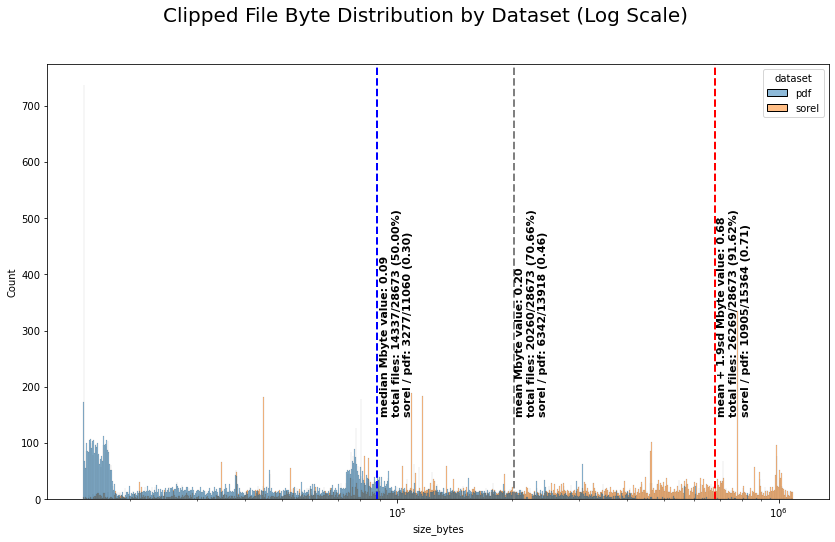

In [242]:
fig, ax = plt.subplots(figsize=(14, 8))

df_clipped = df.loc[lambda df_x: df_x.size_bytes.between(*clip_range)]

sns.histplot(data=df_clipped,
             x='size_bytes',
             hue='dataset',
             ax=ax,
             bins=1000,
             log_scale=True,
             )

fig.suptitle('Clipped File Byte Distribution by Dataset (Log Scale)', fontsize=20)

def add_vline(data, name, stat, color, ax, h_adj=1e5, v_adj=500):
    '''helper to add a vertical line showing chosen byte size and details
    about what files are included when using this line'''
    files = data.loc[lambda df_x: df_x.size_bytes <= stat]
    files_byte_coverage = stat / data.size_bytes.sum()
    sorel_files = files.loc[lambda x: x.dataset == 'sorel']
    pdf_files = files.loc[lambda x: x.dataset == 'pdf']
    ax.axvline(stat, color=color, linewidth=2, linestyle='--')
    text = '\n'.join([
        f'{name} Mbyte value: {stat/1_000_000:.02f}',
        f'total files: {files.shape[0]}/{data.shape[0]} ({files.shape[0] / data.shape[0] * 100:.02f}%)',
        f'sorel / pdf: {sorel_files.shape[0]}/{pdf_files.shape[0]} ({sorel_files.shape[0] / pdf_files.shape[0]:.02f})',
    ])
    ax.text(stat + h_adj, v_adj, text, fontsize=11, fontweight='demibold', rotation=90)

add_vline(df_clipped, 'median', df_clipped.size_bytes.median(), color='blue', ax=ax, h_adj=1e3 + 0.5 * 1e3, v_adj=150)
add_vline(df_clipped, 'mean', df_clipped.size_bytes.mean(), color='grey', ax=ax, h_adj=1e3 + 0.5 * 1e3, v_adj=150)
std_adj = 1.9
add_vline(df_clipped, f'mean + {std_adj}sd', df_clipped.size_bytes.mean() + std_adj * df_clipped.size_bytes.std(), color='red', ax=ax, h_adj=1e4, v_adj=150)

### Using Suggested Adjusted Clipping

Removing the dense set of samples at the pdf data's median by choosing the byte size value at the pdf dataset's 62.5th percentile.

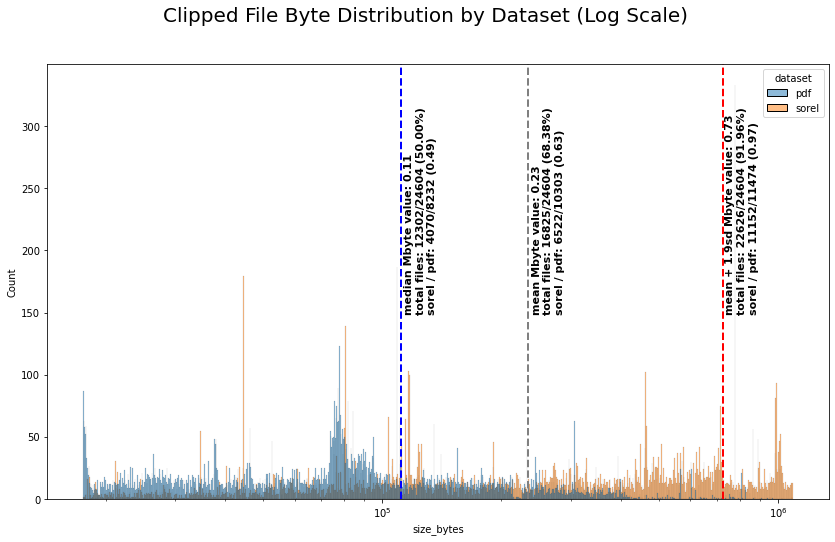

In [243]:
fig, ax = plt.subplots(figsize=(14, 8))

clip_range = (df.loc[lambda x: x.dataset == 'pdf'].size_bytes.quantile(0.625), clip_range[1])
df_clipped = df.loc[lambda df_x: df_x.size_bytes.between(*clip_range)]

sns.histplot(data=df_clipped,
             x='size_bytes',
             hue='dataset',
             ax=ax,
             bins=1000,
             log_scale=True,
             )

fig.suptitle('Clipped File Byte Distribution by Dataset (Log Scale)', fontsize=20)

def add_vline(data, name, stat, color, ax, h_adj=1e5, v_adj=500):
    '''helper to add a vertical line showing chosen byte size and details
    about what files are included when using this line'''
    files = data.loc[lambda df_x: df_x.size_bytes <= stat]
    files_byte_coverage = stat / data.size_bytes.sum()
    sorel_files = files.loc[lambda x: x.dataset == 'sorel']
    pdf_files = files.loc[lambda x: x.dataset == 'pdf']
    ax.axvline(stat, color=color, linewidth=2, linestyle='--')
    text = '\n'.join([
        f'{name} Mbyte value: {stat/1_000_000:.02f}',
        f'total files: {files.shape[0]}/{data.shape[0]} ({files.shape[0] / data.shape[0] * 100:.02f}%)',
        f'sorel / pdf: {sorel_files.shape[0]}/{pdf_files.shape[0]} ({sorel_files.shape[0] / pdf_files.shape[0]:.02f})',
    ])
    ax.text(stat + h_adj, v_adj, text, fontsize=11, fontweight='demibold', rotation=90)

add_vline(df_clipped, 'median', df_clipped.size_bytes.median(), color='blue', ax=ax, h_adj=2*1e3, v_adj=150)
add_vline(df_clipped, 'mean', df_clipped.size_bytes.mean(), color='grey', ax=ax, h_adj=5*1e3, v_adj=150)
std_adj = 1.9
add_vline(df_clipped, f'mean + {std_adj}sd', df_clipped.size_bytes.mean() + std_adj * df_clipped.size_bytes.std(), color='red', ax=ax, h_adj=1e4, v_adj=150)

# By Kind: Benign vs Malicious Split

This is reviewing the same file size distribution visualizations to see what degree of benign vs malicious file imbalance was introduced by this sampling strategy. Unfortunately, this shows that the median byte size of the dataset is the ideal size to pick with respect to achieving a balanced sample of benign vs malicious files. So to split the difference in the tradeoff between the two things that are being balanced here (sorel vs pdf, benign vs malicious), the final strategy for clipping looks like it should be to pick the size that falls between the median file size and the mean + 1.9sd. This gives the "best" of both perspectives, although it's imbalanced.

## Byte Size by Kind Box Plot

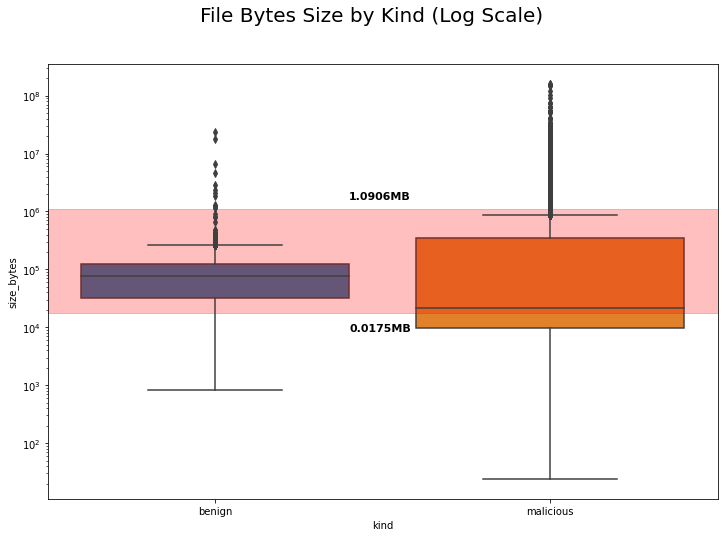

In [244]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.boxplot(data=df,
            x='kind',
            y='size_bytes',
            )
ax.set_yscale('log')

ax.axhspan(*clip_range, color='red', alpha=0.25)
ax.text(0.4, clip_range[0] - 0.5 * clip_range[0], f'{clip_range[0] / 1_000_000:.04f}MB', fontsize=11, fontweight='demibold')
ax.text(0.4, clip_range[1] + 0.5 * clip_range[1], f'{clip_range[1] / 1_000_000:.04f}MB', fontsize=11, fontweight='demibold')

_ = fig.suptitle('File Bytes Size by Kind (Log Scale)', fontsize=20)

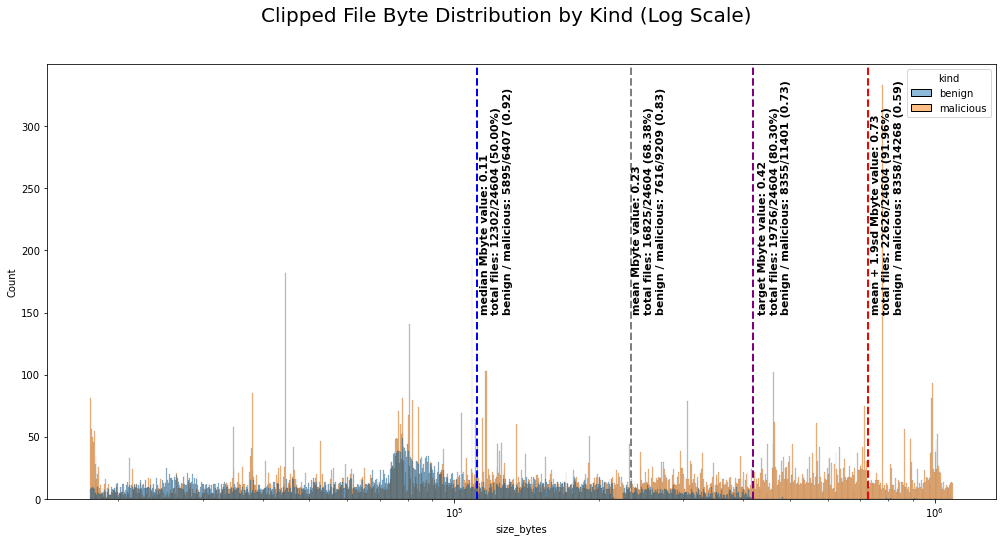

In [245]:
fig, ax = plt.subplots(figsize=(17, 8))

clip_range = (df.loc[lambda x: x.dataset == 'pdf'].size_bytes.quantile(0.625), clip_range[1])
df_clipped = df.loc[lambda df_x: df_x.size_bytes.between(*clip_range)]

sns.histplot(data=df_clipped,
             x='size_bytes',
             hue='kind',
             ax=ax,
             bins=1000,
             log_scale=True,
             )

fig.suptitle('Clipped File Byte Distribution by Kind (Log Scale)', fontsize=20)

def add_vline(data, name, stat, color, ax, h_adj=1e5, v_adj=500):
    '''helper to add a vertical line showing chosen byte size and details
    about what files are included when using this line'''
    files = data.loc[lambda df_x: df_x.size_bytes <= stat]
    files_byte_coverage = stat / data.size_bytes.sum()
    benign_files = files.loc[lambda x: x.kind == 'benign']
    malicious_files = files.loc[lambda x: x.kind == 'malicious']
    ax.axvline(stat, color=color, linewidth=2, linestyle='--')
    text = '\n'.join([
        f'{name} Mbyte value: {stat/1_000_000:.02f}',
        f'total files: {files.shape[0]}/{data.shape[0]} ({files.shape[0] / data.shape[0] * 100:.02f}%)',
        f'benign / malicious: {benign_files.shape[0]}/{malicious_files.shape[0]} ({benign_files.shape[0] / malicious_files.shape[0]:.02f})',
    ])
    ax.text(stat + h_adj, v_adj, text, fontsize=11, fontweight='demibold', rotation=90)

add_vline(df_clipped, 'median', df_clipped.size_bytes.median(), color='blue', ax=ax, h_adj=1e3 + 0.5 * 1e3, v_adj=150)
add_vline(df_clipped, 'mean', df_clipped.size_bytes.mean(), color='grey', ax=ax, h_adj=1e3 + 0.5 * 1e3, v_adj=150)
std_adj = 1.9
add_vline(df_clipped, f'mean + {std_adj}sd', df_clipped.size_bytes.mean() + std_adj * df_clipped.size_bytes.std(), color='red', ax=ax, h_adj=1e4, v_adj=150)
# this is what we should use!
target_split = df_clipped.size_bytes.median() + (df_clipped.size_bytes.mean() + std_adj * df_clipped.size_bytes.std() - df_clipped.size_bytes.median()) / 2
add_vline(df_clipped, f'target', target_split, color='purple', ax=ax, h_adj=1e4, v_adj=150)

## Target Size by Dataset Histogram

Final rehash of the "by Dataset" perspective using the suggested target value found when using the suggested clipping strategy.

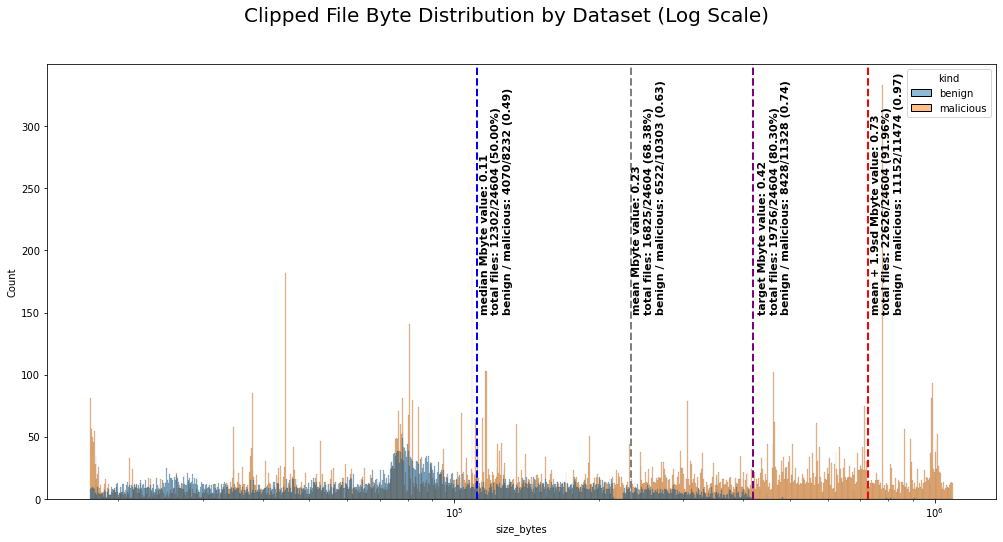

In [246]:
fig, ax = plt.subplots(figsize=(17, 8))

df_clipped = df.loc[lambda df_x: df_x.size_bytes.between(*clip_range)]

sns.histplot(data=df_clipped,
             x='size_bytes',
             hue='kind',
             ax=ax,
             bins=1000,
             log_scale=True,
             )

fig.suptitle('Clipped File Byte Distribution by Dataset (Log Scale)', fontsize=20)

def add_vline(data, name, stat, color, ax, h_adj=1e5, v_adj=500):
    '''helper to add a vertical line showing chosen byte size and details
    about what files are included when using this line'''
    files = data.loc[lambda df_x: df_x.size_bytes <= stat]
    files_byte_coverage = stat / data.size_bytes.sum()
    sorel_files = files.loc[lambda x: x.dataset == 'sorel']
    pdf_files = files.loc[lambda x: x.dataset == 'pdf']
    ax.axvline(stat, color=color, linewidth=2, linestyle='--')
    text = '\n'.join([
        f'{name} Mbyte value: {stat/1_000_000:.02f}',
        f'total files: {files.shape[0]}/{data.shape[0]} ({files.shape[0] / data.shape[0] * 100:.02f}%)',
        f'benign / malicious: {sorel_files.shape[0]}/{pdf_files.shape[0]} ({sorel_files.shape[0] / pdf_files.shape[0]:.02f})',
    ])
    ax.text(stat + h_adj, v_adj, text, fontsize=11, fontweight='demibold', rotation=90)

add_vline(df_clipped, 'median', df_clipped.size_bytes.median(), color='blue', ax=ax, h_adj=1e3 + 0.5 * 1e3, v_adj=150)
add_vline(df_clipped, 'mean', df_clipped.size_bytes.mean(), color='grey', ax=ax, h_adj=1e3 + 0.5 * 1e3, v_adj=150)
std_adj = 1.9
add_vline(df_clipped, f'mean + {std_adj}sd', df_clipped.size_bytes.mean() + std_adj * df_clipped.size_bytes.std(), color='red', ax=ax, h_adj=1e4, v_adj=150)
# this is what we should use!
target_split = df_clipped.size_bytes.median() + (df_clipped.size_bytes.mean() + std_adj * df_clipped.size_bytes.std() - df_clipped.size_bytes.median()) / 2
add_vline(df_clipped, f'target', target_split, color='purple', ax=ax, h_adj=1e4, v_adj=150)

# Takeaways

The H and W value we should use is 648, shown below.

To make that a sensible choice, we should also only be using the filtered set of files from both datasets that are listed in the dataframe below. This has been saved to the root of the GCS dsci591_g4_sorel20m bucket for reference, and it's also saved in the data folder for this notebook, which is available on github / alongside the source of the file size data.

In [247]:
# here's the magic value to use for H and W
math.ceil(math.sqrt(target_split))

648

In [248]:
df_clipped.size_bytes.describe()

count     24604.00
mean     233390.57
std      259325.58
min       17514.00
25%       58646.75
50%      111624.00
75%      311731.00
max     1090490.00
Name: size_bytes, dtype: float64

In [249]:
df_clipped.head()

,size_bytes,modify_time_utc,path,size_kilobytes,size_megabytes,dataset,kind
0,396936,2022-04-30T14:28:00Z,gs://drexel_dsci_2022_g4mic/Benign/unzipped/02...,396.94,0.40,pdf,benign
1,250800,2022-04-30T14:28:00Z,gs://drexel_dsci_2022_g4mic/Benign/unzipped/02...,250.80,0.25,pdf,benign
2,246975,2022-04-30T14:28:00Z,gs://drexel_dsci_2022_g4mic/Benign/unzipped/02...,246.97,0.25,pdf,benign
3,367605,2022-04-30T14:28:00Z,gs://drexel_dsci_2022_g4mic/Benign/unzipped/02...,367.61,0.37,pdf,benign
4,32782,2022-04-30T14:28:00Z,gs://drexel_dsci_2022_g4mic/Benign/unzipped/03...,32.78,0.03,pdf,benign


In [250]:
df_clipped.to_csv(os.path.join(data_dir, 'sorel_pdf_dataset.csv'), index=False)